# Example-based AI explainability analysis

This notebook visualizes the latent space representations of GEFS-Raw and ViT-LDM members.

In [1]:
import os
import sys
import time
import h5py
import numba as nb
import numpy as np
from glob import glob

# ------------------------------------------------------- #
# Turn-off warnings
import logging
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# ------------------------------------------------------- #
# Turn-off tensoflow-specific warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

# ------------------------------------------------------- #
# Import customized modules and settings
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import model_utils as mu
import verif_utils as vu
import graph_utils as gu

In [2]:
# import importlib
# importlib.reload(mu)
# importlib.reload(du)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def norm_precip(x):
    return np.log(0.1*x+1)

In [5]:
# Hyperparameters
filter_nums = [64, 128] # number of convolution kernels per down-/upsampling layer 
latent_dim = 4 # number of latent feature channels
activation = 'gelu' # activation function
num_embeddings = 128 #128 # number of the VQ codes

input_size = (224, 464, 1) # size of MRMS input
latent_size = (14, 29, latent_dim) # size of compressed latent features

drop_encode = True
drop_decode = True

model_name_encoder_load = model_dir+'models/VQ_VAE_encoder_stack1_tune0'
model_name_decoder_load = model_dir+'models/VQ_VAE_decoder_stack1_tune0'

encoder = mu.VQ_VAE_encoder(input_size, filter_nums, latent_dim, num_embeddings, activation, drop_encode)
W_old = mu.dummy_loader(model_name_encoder_load)
encoder.set_weights(W_old)

# decoder = mu.VQ_VAE_decoder(latent_size, filter_nums, activation, drop_decode)
# W_old = mu.dummy_loader(model_name_decoder_load)
# decoder.set_weights(W_old)

### Latent space representations

In [6]:
with h5py.File(camp_dir+'GFS/20210101_mean.hdf', 'r') as h5io:
    GEFS_mean = h5io['apcp_mean'][...]

with h5py.File(camp_dir+'GFS/GEFS_OPT_MEMBERS_2021.hdf', 'r') as h5io:
    GEFS_RAW = h5io['apcp'][0, ...]

with h5py.File(camp_dir+'CCPA/CCPA_lead_y2021.hdf', 'r') as h5io:
    CCPA_true = h5io['CCPA_lead'][0, ...]

filename_LDM = result_dir+'LDM_GEFS_2021_000_033_STEP100_EN155_20240420_ATT0.hdf'
with h5py.File(filename_LDM, 'r') as h5io:
    OUT_LDM = h5io['OUT_refine'][0, ...]
    OUT_ViT = h5io['OUT_no_LDM_refine'][0, ...]

filename = result_dir+'LDM_FULL_GEFS_2021_STEP100_EN062_20240420_ATT0.hdf'
with h5py.File(filename, 'r') as h5io:
    OUT_LDM = h5io['LDM_FULL'][0, ...]

In [7]:
OUT_LDM_encode = mu.encode_mapping(norm_precip(OUT_LDM), encoder, latent_size)
OUT_ViT_encode = mu.encode_mapping(norm_precip(OUT_ViT), encoder, latent_size)
GEFS_RAW_encode = mu.encode_mapping(norm_precip(GEFS_RAW), encoder, latent_size)
CCPA_true_encode = mu.encode_mapping(norm_precip(CCPA_true), encoder, latent_size)
GEFS_mean_encode = mu.encode_mapping(norm_precip(GEFS_mean), encoder, latent_size)

In [8]:
LDM_latent_coords = np.mean(OUT_LDM_encode, axis=(2, 3))
ViT_latent_coords = np.mean(OUT_ViT_encode, axis=(2, 3))
GEFS_latent_coords = np.mean(GEFS_RAW_encode, axis=(2, 3))
MEAN_latent_coords = np.mean(GEFS_mean_encode, axis=(2, 3))
CCPA_latent_coords = np.mean(CCPA_true_encode, axis=(2, 3))

In [9]:
xdim = 0
ydim = 1

latent_info = {}
for ilead in range(24):
    latent_info['ViT_coords_{}'.format(ilead)] = ViT_latent_coords[ilead, :, xdim], ViT_latent_coords[ilead, :, ydim]
    latent_info['LDM_coords_{}'.format(ilead)] = LDM_latent_coords[ilead, :, xdim], LDM_latent_coords[ilead, :, ydim]
    latent_info['CCPA_coords_{}'.format(ilead)] = CCPA_latent_coords[ilead, :, xdim], CCPA_latent_coords[ilead, :, ydim]
    latent_info['GEFS_coords_{}'.format(ilead)] = GEFS_latent_coords[ilead, :, xdim], GEFS_latent_coords[ilead, :, ydim]
    latent_info['MEAN_coords_{}'.format(ilead)] = MEAN_latent_coords[ilead, :, xdim], MEAN_latent_coords[ilead, :, ydim]
    
    for key in ['ViT', 'LDM', 'GEFS']:
        latent_info['{}_KDE_{}'.format(key, ilead)] = du.kde_estimator(latent_info['{}_coords_{}'.format(key, ilead)][0], 
                                                                       latent_info['{}_coords_{}'.format(key, ilead)][1])

# np.save(result_dir+'XAI_verif_new.npy', latent_info, allow_pickle=True)

### Visualization

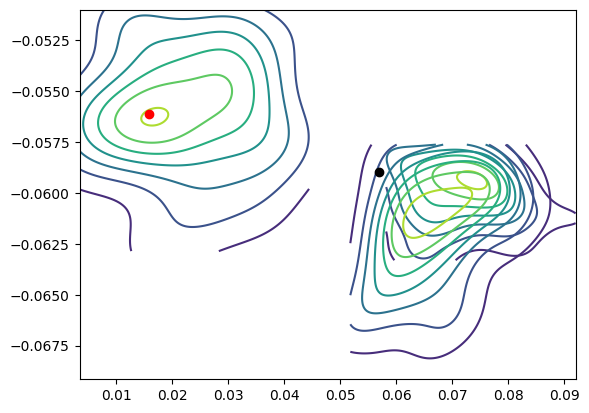

In [10]:
LEAD_plot = [0, 8, 16]

ilead = LEAD_plot[0]

key = 'GEFS'
plt.contour(latent_info['{}_KDE_{}'.format(key, ilead)][0],
            latent_info['{}_KDE_{}'.format(key, ilead)][1],
            latent_info['{}_KDE_{}'.format(key, ilead)][2])

key = 'ViT'
plt.contour(latent_info['{}_KDE_{}'.format(key, ilead)][0],
            latent_info['{}_KDE_{}'.format(key, ilead)][1],
            latent_info['{}_KDE_{}'.format(key, ilead)][2])


key = 'LDM'
plt.contour(latent_info['{}_KDE_{}'.format(key, ilead)][0],
            latent_info['{}_KDE_{}'.format(key, ilead)][1],
            latent_info['{}_KDE_{}'.format(key, ilead)][2])

plt.plot(latent_info['CCPA_coords_{}'.format(ilead)][0], latent_info['CCPA_coords_{}'.format(ilead)][1], 'ko')
plt.plot(latent_info['MEAN_coords_{}'.format(ilead)][0], latent_info['MEAN_coords_{}'.format(ilead)][1], 'ro')

### Full latent space trajectory (x)

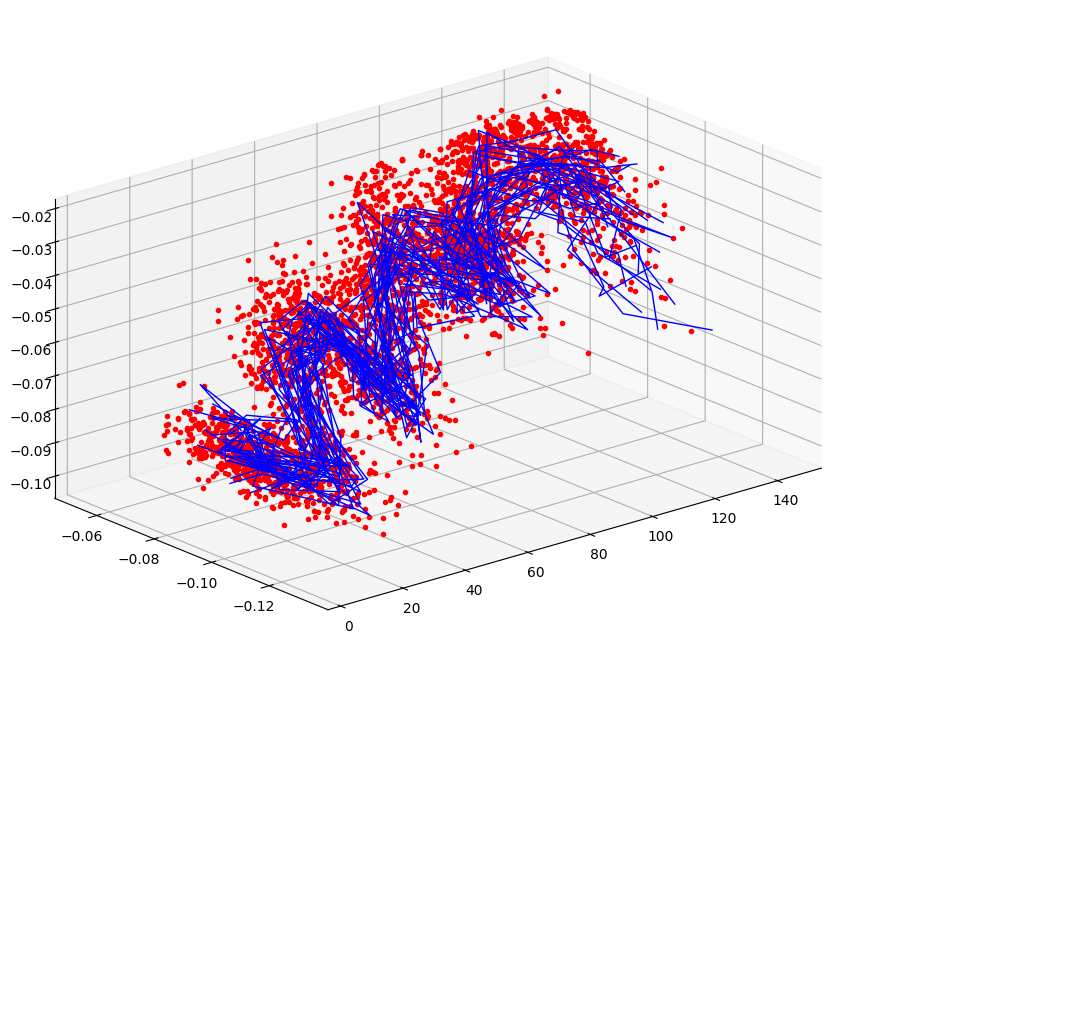

In [146]:
fig = plt.figure(figsize=(13, 13))
ax = plt.axes(projection='3d')

#ax.plot_surface(X_members, Y_leads, LDM_loc1)
lead_interp = np.linspace(6, 144, 100)

for i in range(155):
    ax.plot(leads, LDM_loc1[:, i], LDM_loc2[:, i], 'r.', lw=0.5)

for i in range(31):
    ax.plot(leads, ViT_loc1[:, i], ViT_loc2[:, i], 'b-', lw=1.0)

ax.set_proj_type('ortho')
ax.view_init(elev=20, azim=-130, roll=0)
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.0, 0.66, 0.66, 1]))